# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br>
<br>
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br>
<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [1]:
%%capture
%run ./slovo_three.ipynb ;

In [2]:
import pandas as pd
import numpy as np
import time
from copy import deepcopy
import importlib, utilities.fun_five, utilities.fun_four, utilities.fun_three, utilities.fun_two, utilities.fun_one
importlib.reload(utilities.fun_five)
importlib.reload(utilities.fun_four)
importlib.reload(utilities.fun_three)
importlib.reload(utilities.fun_two)
importlib.reload(utilities.fun_one)
from utilities.fun_five import data_resample, filter_dataframe
from utilities.fun_three import reshape_dataframe
from utilities.fun_four import combine_visualize, ArrayNormalizer, GridClassifier, svm_classify, ada_classify, combine_probabilities, clf_classify
from utilities.fun_two import *
from utilities.fun_one import visualize

In [3]:
%store -r df_records_windowed
df_records_windowed = df_records_windowed

In [4]:
#splt the data into training and testing sets:

#Merge dc and act to one row (one act without dc is omitted)
records_merged = df_records_windowed[df_records_windowed.sensor_code=='dc'].merge(df_records_windowed[df_records_windowed.sensor_code=='act'], on=['subject_id', 'exercise_id', 'trial', 'window_idx'])


train_records, test_records = filter_dataframe(records_merged,ratio=0.25)

In [5]:
train_records

,subject_id,exercise_id,trial,sensor_code_x,sensor_x,df_x,window_idx,sensor_code_y,sensor_y,df_y
1237,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,0,act,acc,act_0 act_1 act_2 0 -0.53688...
1238,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,1,act,acc,act_0 act_1 act_2 0 -0.47076...
1239,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,2,act,acc,act_0 act_1 act_2 0 -0.39624...
1240,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,3,act,acc,act_0 act_1 act_2 0 -0.54393...
1241,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,4,act,acc,act_0 act_1 act_2 0 -0.45366...
...,...,...,...,...,...,...,...,...,...,...
200,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,2,act,acc,act_0 act_1 act_2 0 -1.01111...
201,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,3,act,acc,act_0 act_1 act_2 0 -0.81753...
202,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,4,act,acc,act_0 act_1 act_2 0 -1.01028...
203,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,5,act,acc,act_0 act_1 act_2 0 -0.69702...


In [6]:
test_records

,subject_id,exercise_id,trial,sensor_code_x,sensor_x,df_x,window_idx,sensor_code_y,sensor_y,df_y
1244,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,7,act,acc,act_0 act_1 act_2 0 -0.54130...
1245,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,8,act,acc,act_0 act_1 act_2 0 -0.46576...
1246,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,9,act,acc,act_0 act_1 act_2 0 -0.47009...
1247,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,10,act,acc,act_0 act_1 act_2 0 -0.38110...
1248,01,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,11,act,acc,act_0 act_1 act_2 0 -0.57749...
...,...,...,...,...,...,...,...,...,...,...
223,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,25,act,acc,act_0 act_1 act_2 0 -0.59772...
224,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,26,act,acc,act_0 act_1 act_2 0 -1.01544...
225,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,27,act,acc,act_0 act_1 act_2 0 -0.84742...
226,10,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,28,act,acc,act_0 act_1 act_2 0 -0.98902...


In [7]:
# 5.1

### Your code begins here ###

# Standardize the Data:
act_s = Standardizer()
act_s.fit(train_records,df_name='df_y')
train_records = act_s.transform(train_records,df_name='df_y')
test_records = act_s.transform(test_records,df_name='df_y')

dc_s = Standardizer()
dc_s.fit(train_records,df_name='df_x')
train_records = dc_s.transform(train_records,df_name='df_x')
test_records = dc_s.transform(test_records,df_name='df_x')

labels_train = np.array(train_records.exercise_id.apply(lambda x: int(x)))
labels_test = np.array(test_records.exercise_id.apply(lambda x: int(x)))


train_raw_records = train_records
test_raw_records = test_records

%store train_raw_records
%store test_raw_records

#ACT : -----------------
# Apply PCA:
n_components = 5
pca = PcaActApplier(n_components)
pca.fit(train_records['df_y'])
act_pca_train = pca.transform(train_records['df_y'])
act_pca_test = pca.transform(test_records['df_y'])

#LDA:
n_components = 1
lda = LdaActApplier(n_components)
lda.fit(train_records['df_y'],labels_train)
act_lda_train = lda.transform(train_records['df_y'])
act_lda_test = lda.transform(test_records['df_y'])

act_features = np.concatenate((act_pca_train[0],act_pca_train[1],act_pca_train[2],
                               act_lda_train[0],act_lda_train[1],act_lda_train[2],
                               np.mean(act_pca_train[0],axis=1).reshape(-1,1), np.std(act_pca_train[0],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[1],axis=1).reshape(-1,1), np.std(act_pca_train[1],axis=1).reshape(-1,1),
                               np.mean(act_pca_train[2],axis=1).reshape(-1,1), np.std(act_pca_train[2],axis=1).reshape(-1,1),
                              ),axis=1)

act_test_features = np.concatenate((act_pca_test[0],act_pca_test[1],act_pca_test[2],
                                    act_lda_test[0],act_lda_test[1],act_lda_test[2],
                                    np.mean(act_pca_test[0],axis=1).reshape(-1,1), np.std(act_pca_test[0],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[1],axis=1).reshape(-1,1), np.std(act_pca_test[1],axis=1).reshape(-1,1),
                                    np.mean(act_pca_test[2],axis=1).reshape(-1,1), np.std(act_pca_test[2],axis=1).reshape(-1,1),
                                   ),axis=1)
# DC -------------------
#PCA

n_components = 10
pca_applier = PcaDcApplier(n_components)
pca_applier.fit(train_records,df_name='df_x')
pca_dc_training_records = pca_applier.transform(train_records,df_name='df_x')
pca_dc_testing_records = pca_applier.transform(test_records,df_name='df_x')

pca_dc_training_records_reshaped = deepcopy(pca_dc_training_records)
pca_dc_training_records_reshaped["df_x"] = pca_dc_training_records_reshaped["df_x"].apply(reshape_dataframe)
pca_dc_testing_records_reshaped = deepcopy(pca_dc_testing_records)
pca_dc_testing_records_reshaped["df_x"] = pca_dc_testing_records_reshaped["df_x"].apply(reshape_dataframe)

dc_features = np.concatenate(pca_dc_training_records_reshaped['df_x'].values,axis=0)
dc_test_features = np.concatenate(pca_dc_testing_records_reshaped['df_x'].values,axis=0)




# Normalize the data:
act_normalizer = ArrayNormalizer()
act_normalizer.fit(act_features,axis=0)
act_features = act_normalizer.transform(act_features)
act_test_features = act_normalizer.transform(act_test_features)

dc_normalizer = ArrayNormalizer()
dc_normalizer.fit(dc_features,axis=None)
dc_features = dc_normalizer.transform(dc_features)
dc_test_features = dc_normalizer.transform(dc_test_features)

#Save for use in other notebooks:
%store act_features
%store act_test_features
%store labels_train
%store labels_test
%store dc_features
%store dc_test_features

### Your code ends here ###

Stored 'train_raw_records' (DataFrame)
Stored 'test_raw_records' (DataFrame)
Stored 'act_features' (ndarray)
Stored 'act_test_features' (ndarray)
Stored 'labels_train' (ndarray)
Stored 'labels_test' (ndarray)
Stored 'dc_features' (ndarray)
Stored 'dc_test_features' (ndarray)


In [8]:
# Classification
act_gridsearch_kfold = 10
dc_gridsearch_kfold = 10
act_svm_params = {'C' : [0.1, 1.0, 10.0, 100.0], 'gamma' : [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}
dc_svm_params = {'C' : [0.1, 1.0, 10.0, 100.0], 'gamma' : [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}

act_svm_best = svm_classify(act_features,labels_train,act_test_features,svm_params=act_svm_params,kfold=act_gridsearch_kfold)

dc_svm_best  = svm_classify(dc_features,labels_train,dc_test_features,svm_params=dc_svm_params,kfold=dc_gridsearch_kfold)

print(f"Act model parameters C = {act_svm_best.C} gamma = {act_svm_best.gamma}")
print(f"Dc model parameters C = {dc_svm_best.C} gamma = {dc_svm_best.gamma}")

Act model parameters C = 100.0 gamma = 0.75
Dc model parameters C = 100.0 gamma = 2.0


In [9]:
#from sklearn import svm
#act_svm_best = svm.SVC(C=0.1, kernel='poly',degree=5, gamma=0.5, random_state=0,probability=True, class_weight={1:0.5,2:1,3:1,4:0.5,5:0.5,6:0.5,7:0.5})
#act_svm_best.fit(act_features,labels_train)

In [10]:
#from sklearn.neural_network import MLPClassifier
#act_svm_best = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 200, 500, 200, 50), random_state=0)
#act_svm_best.fit(act_features,labels_train)

In [11]:
# Get the predictions:
act_svm_pred_train = act_svm_best.predict(act_features)
act_svm_pred_test = act_svm_best.predict(act_test_features)
act_svm_proba_train = act_svm_best.predict_proba(act_features)
act_svm_proba_test = act_svm_best.predict_proba(act_test_features)

dc_svm_pred_train =  dc_svm_best.predict(dc_features)
dc_svm_pred_test =   dc_svm_best.predict(dc_test_features)
dc_svm_proba_train = dc_svm_best.predict_proba(dc_features)
dc_svm_proba_test =  dc_svm_best.predict_proba(dc_test_features)

Accelerometer sensor used with svm to classify the subjects
Training data F1 score =  0.9845223077517185
Testing data F1 score =  0.7830043344944441


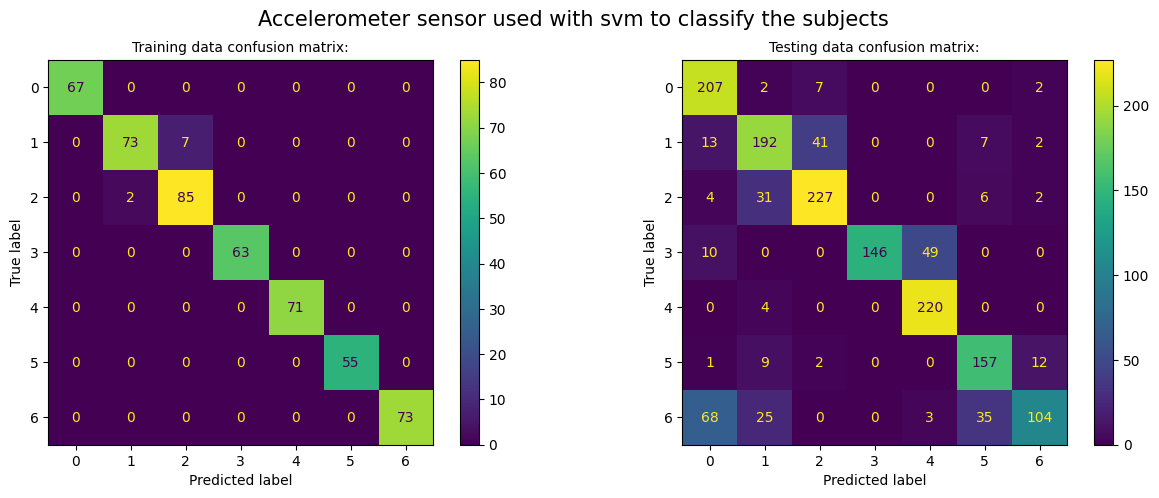

In [12]:
# Visualisation Accelerometer with svm:
visualize(act_svm_pred_train, labels_train, act_svm_pred_test, labels_test,
          main_title="Accelerometer sensor used with svm to classify the subjects")

Depth Camera sensor used with svm to classify the subjects
Training data F1 score =  1.0
Testing data F1 score =  0.9528413254989949


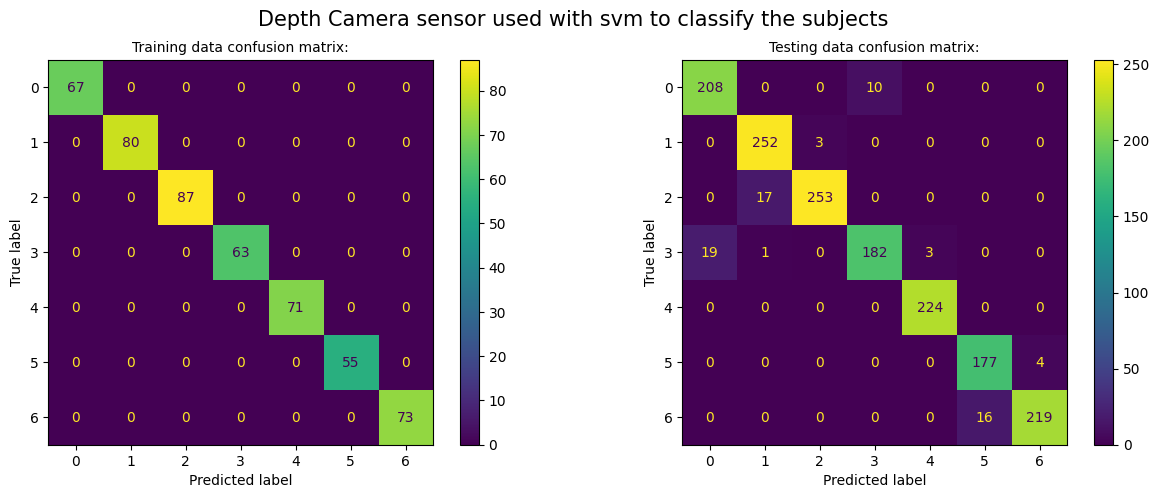

In [13]:
 # Visualisation Depth Camera with svm:
visualize(dc_svm_pred_train, labels_train, dc_svm_pred_test, labels_test,
          main_title="Depth Camera sensor used with svm to classify the subjects")


In [14]:
#Combine the sensours
svm2_train, svm2_test = combine_probabilities(act_svm_proba_train, dc_svm_proba_train,
                                              act_svm_proba_test, dc_svm_proba_test)


Visualize SVM-act and SVM-dc Results :
SVM-act and SVM-dc with mean rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9550260877786274
SVM-act and SVM-dc with sum rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9550260877786274
SVM-act and SVM-dc with prod rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9484538730100384
SVM-act and SVM-dc with max rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9574262404946979
SVM-act and SVM-dc with min rule:
Training data F1 score =  1.0
Testing data F1 score =  0.9367015874889536


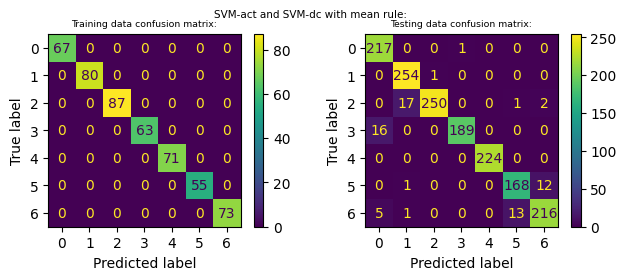

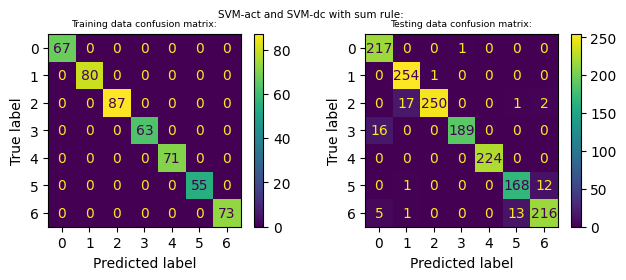

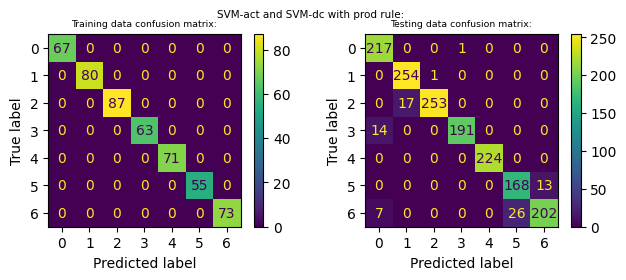

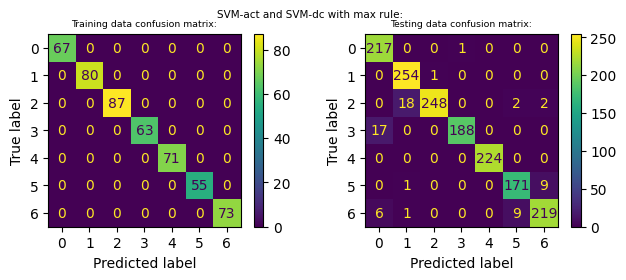

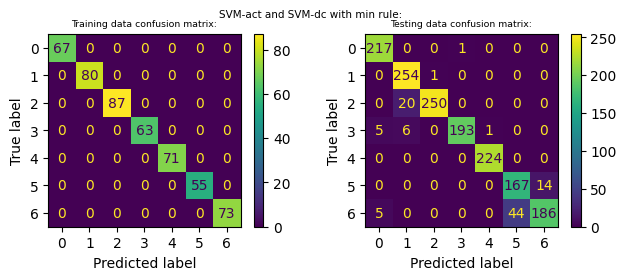

In [15]:
# Combine predictions SVM-act and SVM-dc
combine_visualize(svm2_train, labels_train, svm2_test, labels_test, "SVM-act and SVM-dc")

In [16]:
## 5.2
combined_features = np.concatenate((act_svm_proba_train, dc_svm_proba_train), axis=1)
combined_features_test = np.concatenate((act_svm_proba_test, dc_svm_proba_test), axis=1)
svm_params = {'C': [0.1, 1.0, 10.0, 100.0], 'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}
svm_meta = svm_classify(combined_features, labels_train, combined_features_test, svm_params=svm_params)

#print('C=', svm_meta.C)
#print('gamma=', svm_meta.gamma)

### Your code ends here ###
C = svm_meta.C
gamma = svm_meta.gamma
#svm_meta = svm.SVC(kernel='rbf', random_state=0, gamma=gamma, C=C)
svm_meta.fit(combined_features, labels_train)

SVC(C=0.1, gamma=0.1, probability=True, random_state=0)

In [17]:
svm_pred_train = svm_meta.predict(combined_features)
svm_pred_test = svm_meta.predict(combined_features_test)


Meta SVM-act and SVM-dc
Training data F1 score =  1.0
Testing data F1 score =  0.9513875351554739


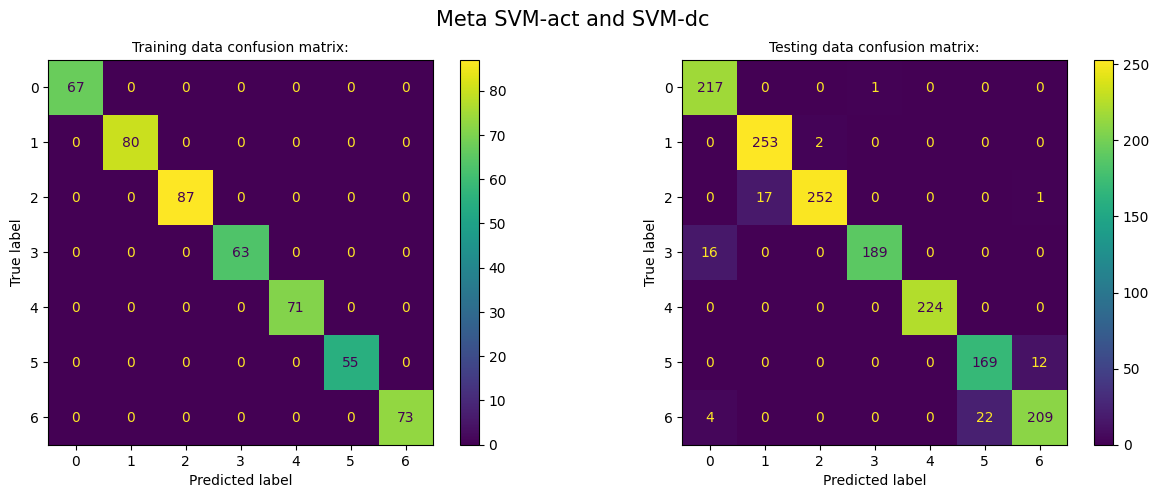

In [18]:
visualize(svm_pred_train, labels_train, svm_pred_test, labels_test, "Meta SVM-act and SVM-dc")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators' : [5,10,20,25,30,35,40,45,50,60], 'max_depth' : [1,2,3,4,5,6,7,8,9,10]}
clf = RandomForestClassifier(random_state=0,max_depth=5)
clf_meta = clf_classify(combined_features, labels_train, combined_features_test, svm_params = params)
clf = clf.fit(combined_features, labels_train)
svm_pred_train =  clf.predict(combined_features)
svm_pred_test =   clf.predict(combined_features_test)
visualize(svm_pred_train,labels_train,svm_pred_test,labels_test,"Random Forest")

In [ ]:
## Combine on the data level
combined_features = np.concatenate((act_features,dc_features),axis=1)
combined_test_features = np.concatenate((act_test_features,dc_test_features),axis=1)
combined_params = {'C': [0.1, 1.0, 10.0, 100.0], 'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}
combined_svm = svm_classify(combined_features, labels_train, combined_test_features, svm_params=combined_params)
pred_train = combined_svm.predict(combined_features)
pred_test = combined_svm.predict(combined_test_features)

visualize(pred_train, labels_train, pred_test, labels_test, "Meta SVM-act and SVM-dc")

